In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import os, glob, sys
from tqdm import tqdm
import pandas as pd

Remarks:

For py main.py --image_path "train_img" --label_path "label_train.txt" --batch_size 128 --lr 0.001 --epochs 100 --training_mode Val
Epoch 5 to 8 - rerun
 HTER Train: 0.0775
 f1-score Train: 0.9457

Model saved of epoch 10
Train F1 Score: 0.9666
Validation F1 Score: 0.9499
Train ROC AUC: 0.9618
Validation ROC AUC: 0.8970
HTER Train: 0.0382
HTER Val: 0.1030



In [3]:
path_training = 'train_img'
path_val = 'val_img'
label_file = 'label_train.txt'

In [4]:
# Load les labels
df = pd.read_csv(label_file, sep=',', header=None)
df.columns = ['label']
print('############################')
print('Label du fichier label_train.txt')
print(df.head())
print('\n')
print(f'Nombre de valeurs dans le df len({len(df)})- verification pas d\'outlier')
print(df.nunique())
print('\n')
print(f'Nombre d\'occurences de chaque label')
print(df.value_counts())
print('############################')

############################
Label du fichier label_train.txt
   label
0      1
1      1
2      1
3      1
4      1


Nombre de valeurs dans le df len(100000)- verification pas d'outlier
label    2
dtype: int64


Nombre d'occurences de chaque label
label
1        87898
0        12102
Name: count, dtype: int64
############################


## 2. Hypothèse
Jeu de training et test ne comporte que des visages différents - à vérifier si performances ~~

In [51]:
def load_and_normalize_images(image_dir: str):
    images:list = []

    for filename in tqdm(os.listdir(image_dir)):
        if filename.endswith(".jpg"):

            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path) # Load plus rapide avec PIL que plt
            img_array = np.array(img)
            img_array = img_array.astype('float32') / 255.0

            images.append(img_array)
            
    images = np.array(images)
    
    return images

In [6]:
image_directory = path_training
normalized_images = load_and_normalize_images(image_directory)


100%|██████████| 100000/100000 [01:02<00:00, 1592.87it/s]


### Display

Text(0.5, 1.0, 'Image n°12858 - label: 0')

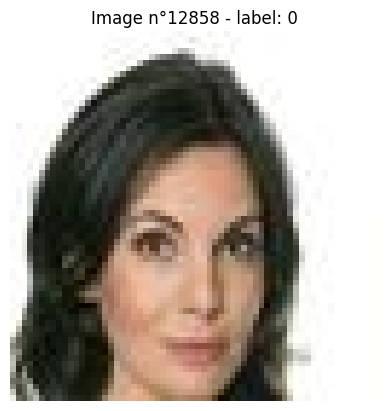

In [37]:
num_image = np.random.choice(len(normalized_images))
show_image_title = df.iloc[num_image]['label']
show_image = normalized_images[num_image]
plt.imshow(show_image)
plt.axis('off')
plt.title(f'Image n°{num_image} - label: {show_image_title}')

## Affichage label 0 et label 1

In [32]:
import time
import math
def get_sample(image_set: np.ndarray, labels: np.ndarray, n_draw: int, flag_display=False):
    """
    Display random samples with labels in a grid.

    Parameters:
        image_set (np.ndarray): A NumPy array of images.
        labels (np.ndarray): A NumPy array of labels.
        n_draw (int): Number of samples to draw randomly from image set
        
    Returns:
        np.ndarray: A NumPy array of indices of drawn images.
    """
    # Select n_draw random images and corresponding labels from the set
    indices = np.random.choice(len(image_set), size=n_draw, replace=False)
    sample_images = image_set[indices]
    sample_labels = labels[indices]

    combined = list(zip(sample_labels, sample_images))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    sorted_labels, sorted_normalized_image = zip(*sorted_combined)

    sorted_labels = list(sorted_labels)
    sorted_normalized_image = list(sorted_normalized_image)

    
    if flag_display == True:
        # Grid parameters
        cols = int(math.ceil(math.sqrt(n_draw)))
        rows = int(math.ceil(n_draw / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
        
        for i, ax in enumerate(axes.flatten()):
            if i < n_draw:
                ax.imshow(sorted_normalized_image[i])
                ax.axis('off')
                ax.set_title(f"Label: {sorted_labels[i]}")
            else:
                ax.axis('off')  

        plt.tight_layout()
        plt.show()
        
        # Wait for 2 seconds
        time.sleep(2)
        
        # Close the figure
        plt.close(fig)
    

In [ ]:
n_draw = 100
X = normalized_images
y = df['label'].values
y = np.float32(y)
images_0,images_1 = [], []
label_0,label_1 = [], []

# Loop through the sorted labels and images and separate them based on the label
for label, image in zip(y, normalized_images):
    if label == 0:
        images_0.append(image)
        label_0.append(label)

    else:
        images_1.append(image)
        label_1.append(label)
images_0 = np.asarray(images_0)
label_0 = np.asarray(label_0)
images_1 = np.asarray(images_1)
label_1 = np.asarray(label_1)


In [48]:
import time
import math
def get_sample_prediction(image_set: np.ndarray, labels: np.ndarray, prediction: np.ndarray, n_draw: int, flag_display=False):
    """
    Display random samples with labels in a grid.

    Parameters:
        image_set (np.ndarray): A NumPy array of images.
        labels (np.ndarray): A NumPy array of labels.
        n_draw (int): Number of samples to draw randomly from image set
        
    Returns:
        np.ndarray: A NumPy array of indices of drawn images.
    """
    # Select n_draw random images and corresponding labels from the set
    indices = np.random.choice(len(image_set), size=n_draw, replace=False)
    sample_images = image_set[indices]
    sample_labels = labels[indices]
    sample_predicted = prediction[indices]

    combined = list(zip(sample_labels, sample_images, sample_predicted))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    sorted_labels, sorted_normalized_image , sorted_sample_predicted = zip(*sorted_combined)

    sorted_labels = list(sorted_labels)
    sorted_normalized_image = list(sorted_normalized_image)

    if flag_display == True:
        # Grid parameters
        cols = int(math.ceil(math.sqrt(n_draw)))
        rows = int(math.ceil(n_draw / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
        
        for i, ax in enumerate(axes.flatten()):
            if i < n_draw:
                ax.imshow(sorted_normalized_image[i])
                ax.axis('off')
                ax.set_title(f"Label: {sorted_labels[i]} - Pred {sorted_sample_predicted[i]}")
            else:
                ax.axis('off')  

        plt.tight_layout()
        plt.show()
        
        # Wait for 2 seconds
        time.sleep(2)
        
        # Close the figure
        plt.close(fig)


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
# It seems to have learned to classify glasses
best_model = load_model('run/log_2024_09_03_15_29_29_epochs_100_lr_0.001_batch_size_128_fold_X/cnn_model.keras')
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
y_pred_prob_test = best_model.predict(x_val)

threshold = 0.5
y_pred_test= (y_pred_prob_test > threshold).astype(int)

get_sample(x_val, y_val,y_pred_test, n_draw=n_draw, flag_display=True)

In [ ]:
get_sample(images_0, label_0, n_draw=n_draw, flag_display=True)
get_sample(images_1, label_1, n_draw=n_draw, flag_display=True)

In [40]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
# It seems to have learned to classify glasses
best_model = load_model('run/log_2024_09_03_15_29_29_epochs_100_lr_0.001_batch_size_128_fold_X/cnn_model.keras')
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
y_pred_prob_test = best_model.predict(x_val)

threshold = 0.5
y_pred_test= (y_pred_prob_test > threshold).astype(int)


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step


In [41]:
images_0,images_1 = [], []
label_0,label_1 = [], []
pred_0, pred_1 = [], []

# Loop through the sorted labels and images and separate them based on the label
for label, image, pred in zip(y_val, x_val, y_pred_test):
    if label == 0:
        images_0.append(image)
        label_0.append(label)
        pred_0.append(pred)

    else:
        images_1.append(image)
        label_1.append(label)
        pred_1.append(pred)

images_0 = np.asarray(images_0)
label_0 = np.asarray(label_0)
pred_0 = np.asarray(pred_0)
images_1 = np.asarray(images_1)
label_1 = np.asarray(label_1)
pred_1 = np.asarray(pred_1)

In [ ]:
get_sample_prediction(images_0, label_0, pred_0, n_draw=n_draw, flag_display=True)
get_sample_prediction(images_1, label_1, pred_1, n_draw=n_draw, flag_display=True)

## Prediction on Test set

In [52]:
image_directory = path_val
normalized_images = load_and_normalize_images(image_directory)

100%|██████████| 20000/20000 [00:16<00:00, 1194.97it/s]


In [53]:
best_model = load_model('run/log_2024_09_03_15_29_29_epochs_100_lr_0.001_batch_size_128_fold_X/cnn_model.keras')
y_pred_prob_test = best_model.predict(normalized_images)


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step


In [56]:
threshold=0.5
y_pred_test = (y_pred_prob_test > threshold).astype(int)
np.savetxt("output.csv", y_pred_test, delimiter=",", header="Predicted Label", comments='', fmt='%d')

## Split

In [6]:
# import sklearn 
# from sklearn.model_selection import train_test_split
# X_train, x_val, y_train, y_val = train_test_split(normalized_images, df, test_size=0.2, random_state=1)

In [7]:
image_shape = show_image.shape
X = normalized_images
y = df['label'].values
y = np.float32(y)
print(f'Shape des données {image_shape}')

Shape des données (64, 64, 3)


Ce sont des images couleurs RGB de 3 channels. Construction d'un modèle avec cross validation pour détermination du genre.

## Construction du modèle

In [8]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import io
import yaml
from sklearn.metrics import f1_score, roc_auc_score

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import io

# Callbacks https://stackabuse.com/custom-keras-callback-for-saving-prediction-on-each-epoch-with-visualizations/
class PerformancePlotCallbackTrain(keras.callbacks.Callback):
    def __init__(self, x_val, y_val, model_name, file_writer):
        self.x_val = x_val
        self.y_val = y_val
        self.model_name = model_name
        self.file_writer = file_writer

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image


    def log_predictions_to_tensorboard(self, label, epoch):
    # Select 6 random images from the set
        indices = np.random.choice(len(self.x_val), size=6, replace=False)
        sample_images = self.x_val[indices]
        sample_labels = self.y_val[indices]
        threshold = 0.5
        y_pred_prob_val = self.model.predict(sample_images)
        predictions =  (y_pred_prob_val > threshold).astype(int)
        
        # Create a matplotlib figure
        fig, axes = plt.subplots(2, 3, figsize=(8, 6))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(sample_images[i])
            ax.axis('off')
            ax.set_title(f"True: {sample_labels[i]} - Pred: {predictions[i]}")

        with self.file_writer.as_default():
            tf.summary.image(f'Predictions {label}', plot_to_image(fig), step=0)



    def calculate_hter(self):
        """
        Calculate the Half Total Error Rate (HTER) given the true labels and predicted labels.
        
        Parameters:
        - y_val: List or array of true labels
        - y_pred_val: List or array of predicted labels
        
        Returns:
        - HTER: Half Total Error Rate (float)
        """
        # Compute confusion matrix
        threshold = 0.5
        y_pred_prob_val = self.model.predict(self.x_val)
        y_pred_val =  (y_pred_prob_val > threshold).astype(int)
        cm = confusion_matrix(self.y_val, y_pred_val)
        
        # Ensure the confusion matrix has the expected shape
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            raise ValueError("Confusion matrix must be 2x2 for binary classification.")
        
        # Calculate FAR and FRR
        FAR = fp / (fp + tn) if (fp + tn) > 0 else 0
        FRR = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        # Calculate HTER
        HTER = (FAR + FRR) / 2
        f1_score_train = f1_score(self.y_val, y_pred_val)
        print(f'HTER Train: {HTER:.4f}')
        print(f'f1-score Train: {f1_score_train:.4f}')
        with self.file_writer.as_default():
    
            tf.summary.scalar(f'HTER Train', HTER, step=0)
            tf.summary.scalar(f'f1-score Train:', f1_score_train , step=0)

        return HTER

    def on_epoch_end(self, epoch, logs={}):
        if (epoch+1)%5==0:
            self.log_predictions_to_tensorboard(f'{self.model_name} Epoch {epoch}', 
                                                epoch)
            self.calculate_hter()

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import io

# Callbacks https://stackabuse.com/custom-keras-callback-for-saving-prediction-on-each-epoch-with-visualizations/
class PerformancePlotCallbackVal(keras.callbacks.Callback):
    def __init__(self, x_val, y_val, model_name, file_writer):
        self.x_val = x_val
        self.y_val = y_val
        self.model_name = model_name
        self.file_writer = file_writer

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image


    def log_predictions_to_tensorboard(self, label):
    # Select 6 random images from the set
        indices = np.random.choice(len(self.x_val), size=6, replace=False)
        sample_images = self.x_val[indices]
        sample_labels = self.y_val[indices]
        threshold = 0.5
        y_pred_prob_val = self.model.predict(sample_images)
        predictions =  (y_pred_prob_val > threshold).astype(int)

        
        # Create a matplotlib figure
        fig, axes = plt.subplots(2, 3, figsize=(8, 6))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(sample_images[i])
            ax.axis('off')
            ax.set_title(f"True: {sample_labels[i]} - Pred: {predictions[i]}")

        with self.file_writer.as_default():
            tf.summary.image(f'Predictions {label}', plot_to_image(fig), step=0)



    def calculate_hter(self):
        """
        Calculate the Half Total Error Rate (HTER) given the true labels and predicted labels.
        
        Parameters:
        - y_val: List or array of true labels
        - y_pred_val: List or array of predicted labels
        
        Returns:
        - HTER: Half Total Error Rate (float)
        """
        # Compute confusion matrix

        threshold = 0.5
        y_pred_prob_val = self.model.predict(self.x_val)
        y_pred_val =  (y_pred_prob_val > threshold).astype(int)

        cm = confusion_matrix(self.y_val, y_pred_val)
        
        # Ensure the confusion matrix has the expected shape
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            raise ValueError("Confusion matrix must be 2x2 for binary classification.")
        
        # Calculate FAR and FRR
        FAR = fp / (fp + tn) if (fp + tn) > 0 else 0
        FRR = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        # Calculate HTER
        HTER = (FAR + FRR) / 2
        f1_score_val = f1_score(self.y_val, y_pred_val)
        print(f'HTER Validation: {HTER:.4f}')
        print(f'f1-score Validation: {f1_score_val}')
        with self.file_writer.as_default():
            tf.summary.scalar(f'HTER Validation', HTER, step=0)
            tf.summary.scalar(f'f1-score Validation:', f1_score_val , step=0)
        return HTER


    def on_test_end(self, logs={}):
            self.log_predictions_to_tensorboard(f'{self.model_name} at Validation')
            self.calculate_hter()




In [11]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def calculate_hter(x_val, y_val, model):
    """
    Calculate the Half Total Error Rate (HTER) given the true labels and predicted labels.
    
    Parameters:
    - y_val: List or array of true labels
    - y_pred_val: List or array of predicted labels
    
    Returns:
    - HTER: Half Total Error Rate (float)
    """
    # Compute confusion matrix
    threshold = 0.5
    y_pred_prob_val = model.predict(x_val)
    y_pred_val =  (y_pred_prob_val > threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred_val)
    
    # Ensure the confusion matrix has the expected shape
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        raise ValueError("Confusion matrix must be 2x2 for binary classification.")
    
    # Calculate FAR and FRR
    FAR = fp / (fp + tn) if (fp + tn) > 0 else 0
    FRR = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Calculate HTER
    HTER = (FAR + FRR) / 2
    
    return HTER

In [12]:
from sklearn.model_selection import StratifiedKFold
def train_and_evaluate_model_crossVal(X, y, batch_size=32, learning_rate=0.001, epochs=100, n_splits=5):

    image_shape = (64, 64, 3)
    
    start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    log_dir = 'run/log_' + str(start_time) + '_epochs_' + str(epochs) + '_lr_' + str(learning_rate)+ '_batch_size_' + str(batch_size)

    
    hter_scores = []
    f1_score_train_list = []
    f1_score_val_list = []
    roc_train_list = []
    roc_val_list = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_index, val_index) in tqdm(enumerate(skf.split(X))):
        log_dir += '_fold_' + str(fold)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        # Save best models per Fold
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        checkpoint_path = os.path.join(log_dir, '_fold_' + str(fold) + "_cnn_model.keras")
        checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True)

        params = {
            'run': f'log_{start_time}_epochs_{epochs}_lr_{learning_rate}_batch_size_{batch_size}'
        }

        # Define the YAML file path within logdir
        yaml_file_path = os.path.join(log_dir, 'parameters.yaml')
        with open(yaml_file_path, 'w') as file:
            yaml.dump(params, file, default_flow_style=False)
            
        file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
        X_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Model architecture
        model = Sequential()
        model.add(Input(shape=image_shape))
        model.add(Conv2D(36, (3, 3), activation='relu'))
        model.add(Conv2D(48, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(72, (3, 3), activation='relu'))
        model.add(Conv2D(72, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))  
        model.add(Dense(1, activation='sigmoid'))


        optimizer = Adam(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', hter_metric])

        
        performance_train = PerformancePlotCallbackTrain(X_train, y_train, "CNN_model_train", file_writer)
        performance_val = PerformancePlotCallbackVal(x_val, y_val, "CNN_model_val", file_writer)
        
        history = model.fit(X_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(x_val, y_val),
                            callbacks=[tensorboard_callback, performance_train, performance_val],
                            verbose=1)
        


        y_pred_prob_train = model.predict(X_train)
        y_pred_prob_val = model.predict(x_val)

        threshold = 0.5
        y_pred_train = (y_pred_prob_train > threshold).astype(int)
        y_pred_val = (y_pred_prob_val > threshold).astype(int)

        f1_train = f1_score(y_train, y_pred_train)
        roc_auc_train = roc_auc_score(y_train, y_pred_train)
        f1_score_train_list.append(f1_train)
        roc_train_list.append(roc_auc_train)

        f1_val= f1_score(y_train, y_pred_val)
        roc_auc_val = roc_auc_score(y_val, y_pred_val)
        f1_score_val_list.append(f1_val)
        roc_val_list.append(roc_auc_val)
        
        HTER = calculate_hter(x_val, y_val, model)
        
        hter_scores.append(HTER)

    average_f1_score_train = np.mean(f1_score_train_list)
    average_f1_score_val = np.mean(f1_score_val_list)
    average_roc_train = np.mean(roc_train_list)
    average_roc_val_list = np.mean(roc_val_list) 

    average_hter = np.mean(hter_scores)

    print(f'Average f1 train: {average_f1_score_train:.6f}')
    print(f'Average f1 val: {average_f1_score_val:.6f}')
    print(f'Average ROC train: {average_roc_train:.6f}')
    print(f'Average ROC val: {average_roc_val_list:.6f}')
    print(f'Average HTER: {average_hter:.4f}')
    
    return average_hter





    






In [13]:
def hter_metric(y_true, y_pred):
    # Convert predictions to binary
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    
    # Compute True Positives, True Negatives, False Positives, False Negatives
    TP = tf.reduce_sum(y_true * y_pred_binary)
    TN = tf.reduce_sum((1 - y_true) * (1 - y_pred_binary))
    FP = tf.reduce_sum((1 - y_true) * y_pred_binary)
    FN = tf.reduce_sum(y_true * (1 - y_pred_binary))
    
    # Compute FAR and FRR
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)

    total_FP_TN = FP + TN
    total_FN_TP = FN + TP
    FAR = tf.cond(tf.greater(total_FP_TN, 0), lambda: FP / total_FP_TN, lambda: tf.constant(0.0))
    FRR = tf.cond(tf.greater(total_FN_TP, 0), lambda: FN / total_FN_TP, lambda: tf.constant(0.0))
    
    # Compute HTER
    HTER = 0.5 * (FAR + FRR)
    
    return HTER

def train_and_evaluate_model(X, y, batch_size=32, learning_rate=0.001, epochs=100):

    image_shape = (64, 64, 3)
    
    start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    log_dir = 'run/log_' + str(start_time) + '_epochs_' + str(epochs) + '_lr_' + str(learning_rate)+ '_batch_size_' + str(batch_size)

     
    fold = 'X'
    log_dir += '_fold_' + str(fold)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Save best models per Fold
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    checkpoint_path = os.path.join(log_dir, '_fold_' + str(fold) + "_cnn_model.keras")
    checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True)

    params = {
        'run': f'log_{start_time}_epochs_{epochs}_lr_{learning_rate}_batch_size_{batch_size}'
    }

    # Define the YAML file path within logdir
    yaml_file_path = os.path.join(log_dir, 'parameters.yaml')
    with open(yaml_file_path, 'w') as file:
        yaml.dump(params, file, default_flow_style=False)
        
    file_writer = tf.summary.create_file_writer(log_dir + "/metrics")#


    X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


    # Model architecture
    model = Sequential()
    model.add(Input(shape=image_shape))
    model.add(Conv2D(36, (3, 3), activation='relu'))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(72, (3, 3), activation='relu'))
    model.add(Conv2D(72, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))  
    model.add(Dense(1, activation='sigmoid'))


    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', hter_metric])

    
    performance_train = PerformancePlotCallbackTrain(X_train, y_train, "CNN_model_train", file_writer)
    performance_val = PerformancePlotCallbackVal(x_val, y_val, "CNN_model_val", file_writer)
    
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_val, y_val),
                        callbacks=[tensorboard_callback, performance_train, performance_val],
                        verbose=1)
    


    y_pred_prob_train = model.predict(X_train)
    y_pred_prob_val = model.predict(x_val)

    threshold = 0.5
    y_pred_train = (y_pred_prob_train > threshold).astype(int)
    y_pred_val = (y_pred_prob_val > threshold).astype(int)

    f1_train = f1_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    
    f1_val = f1_score(y_val, y_pred_val)
    roc_auc_val = roc_auc_score(y_val, y_pred_val)

    HTER = calculate_hter(x_val, y_val, model)

    print(f"Train F1 Score: {f1_train:.4f}")
    print(f"Validation F1 Score: {f1_val:.4f}")
    print(f"Train ROC AUC: {roc_auc_train:.4f}")
    print(f"Validation ROC AUC: {roc_auc_val:.4f}")
    
    print(f' HTER: {HTER:.4f}')
    
    return HTER



In [14]:
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping

def train_and_evaluate_model_classWeight(X, y, batch_size=32, learning_rate=0.001, epochs=100):
    image_shape = (64, 64, 3)
    
    start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    log_dir = 'run/log_' + str(start_time) + '_epochs_' + str(epochs) + '_lr_' + str(learning_rate) + '_batch_size_' + str(batch_size)

    fold = 'X'
    log_dir += '_fold_' + str(fold)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    checkpoint_path = os.path.join(log_dir, '_fold_' + str(fold) + "_cnn_model.keras")
    # checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_hter_metric', save_best_only=True)
    checkpoint_callback = ModelCheckpoint(checkpoint_path,  save_best_only=True)

    params = {
        'run': f'log_{start_time}_epochs_{epochs}_lr_{learning_rate}_batch_size_{batch_size}'
    }

    yaml_file_path = os.path.join(log_dir, 'parameters.yaml')
    with open(yaml_file_path, 'w') as file:
        yaml.dump(params, file, default_flow_style=False)
    
    early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=10,                 
    verbose=1,                  
    restore_best_weights=True    
)
    

    file_writer = tf.summary.create_file_writer(log_dir + "/metrics")

    X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
    
    # Compute class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Model architecture
    model = Sequential()
    model.add(Input(shape=image_shape))
    model.add(Conv2D(36, (3, 3), activation='relu'))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(72, (3, 3), activation='relu'))
    model.add(Conv2D(72, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))  
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', hter_metric])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', hter_metric])

    performance_train = PerformancePlotCallbackTrain(X_train, y_train, "CNN_model_train", file_writer)
    performance_val = PerformancePlotCallbackVal(x_val, y_val, "CNN_model_val", file_writer)
    
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, tensorboard_callback, performance_train, performance_val, checkpoint_callback],
                        class_weight=class_weights_dict,  
                        verbose=1)
    
    y_pred_prob_train = model.predict(X_train)
    y_pred_prob_val = model.predict(x_val)

    threshold = 0.5
    y_pred_train = (y_pred_prob_train > threshold).astype(int)
    y_pred_val = (y_pred_prob_val > threshold).astype(int)

    f1_train = f1_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    
    f1_val = f1_score(y_val, y_pred_val)
    roc_auc_val = roc_auc_score(y_val, y_pred_val)

    HTER = calculate_hter(x_val, y_val, model)

    print(f"Train F1 Score: {f1_train:.4f}")
    print(f"Validation F1 Score: {f1_val:.4f}")
    print(f"Train ROC AUC: {roc_auc_train:.4f}")
    print(f"Validation ROC AUC: {roc_auc_val:.4f}")
    
    print(f' HTER: {HTER:.4f}')
    
    return HTER

In [15]:
BATCH_SIZE=256
LR = 0.001
EPOCHS = 100
from tensorflow.keras.layers import Conv2D, Input
average_hter = train_and_evaluate_model_classWeight(X, y, batch_size=BATCH_SIZE, learning_rate=LR, epochs=EPOCHS)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/stepstep - accuracy: 0.6919 - hter_metric: 0.5000 - loss: 0.57
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step
HTER: 0.1500
f1-score: 0.9197382638972266
313/313 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.6922 - hter_metric: 0.5000 - loss: 0.5722 - val_accuracy: 0.8663 - val_hter_metric: 0.5000 - val_loss: 0.3160
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.8400 - hter_metric: 0.5000 - loss: 0.336
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step
HTER: 0.1494
f1-score: 0.8438318491356731
313/313 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.8400 - hter_metric: 0.5000 - loss: 0.3364 - val_accuracy: 0.7615 - val_hter_metric: 0.5000 - val_loss: 0.4864
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step/step - accuracy: 0.8671 - hter_metric: 0.5000 - loss: 0.277
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step
HTER: 0.1030
f1-score: 0.9229835896502563
313/313 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.8671 - hter_metric: 0.5000 -

NameError: name 'self' is not defined

In [ ]:
BATCH_SIZE=128
LR = 0.001
EPOCHS = 100
from tensorflow.keras.layers import Conv2D, Input
average_hter = train_and_evaluate_model_classWeight(X, y, batch_size=BATCH_SIZE, learning_rate=LR, epochs=EPOCHS)


Epoch 1/100
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7334 - hter_metric: 0.5000 - loss: 0.8603

KeyboardInterrupt: 

In [ ]:
BATCH_SIZE=256
LR = 0.001
EPOCHS = 100
N_SPLITS=5
from tensorflow.keras.layers import Conv2D, Input
average_hter = train_and_evaluate_model_crossVAL(X, y,  batch_size=BATCH_SIZE, learning_rate=LR, epochs=EPOCHS, , n_splits=N_SPLITS)

## Experiment tracking

In [ ]:
yaml_file_path:str = 
with open(yaml_file_path, 'r') as file:
    loaded_params = yaml.safe_load(file)

print("Loaded parameters:", loaded_params)

## Test

In [16]:
image_directory = path_val
normalized_images = load_and_normalize_images(image_directory, df)

100%|██████████| 20000/20000 [00:15<00:00, 1327.96it/s]


In [20]:
def label_predictions(image_set, predicted_label):
# Select 6 random images from the set
    indices = np.random.choice(len(image_set), size=6, replace=False)
    sample_images = image_set[indices]
    sample_labels = predicted_label[indices]


    
    # Create a matplotlib figure
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(sample_images[i])
        ax.axis('off')
        ax.set_title(f"Pred: {sample_labels[i]}")
    plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step


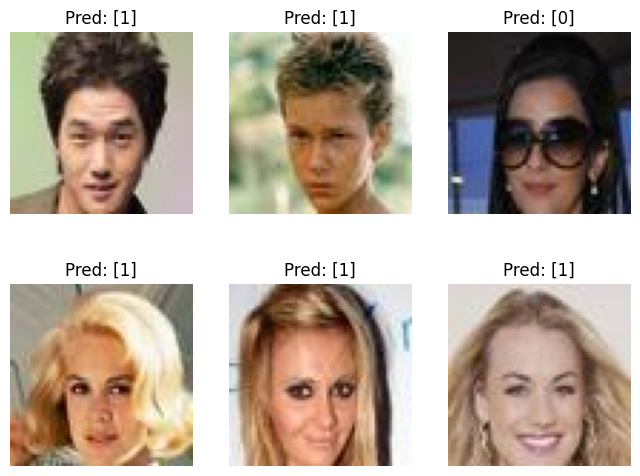

In [22]:
from tensorflow.keras.models import load_model
# It seems to have learned to classify glasses
best_model = load_model('_fold_0_cnn_model.keras')
x_val = normalized_images
y_pred_prob_test = best_model.predict(x_val)



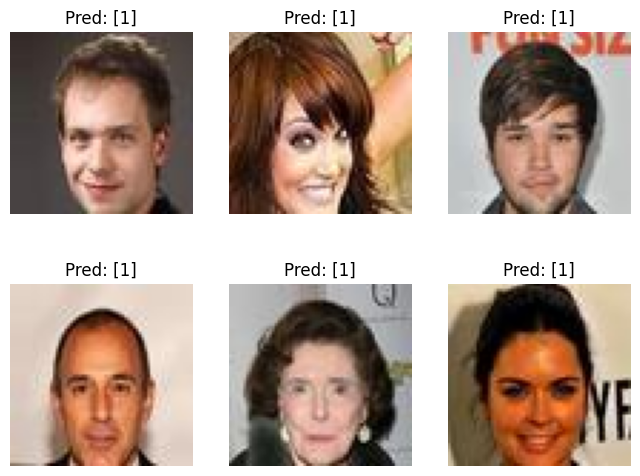

In [28]:
threshold = 0.5
y_pred_test= (y_pred_prob_test > threshold).astype(int)

label_predictions(x_val, y_pred_test)